In [1]:
# 收在下布林，且下影線大於實體Ｋ及上影線，加入EMA
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1609471585000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low        Volume
0     2021-01-01 15:59:59   744.87   737.38   747.09   734.40   72474.10311
1     2021-01-01 19:59:59   737.37   738.85   741.76   725.10  128108.21447
2     2021-01-01 23:59:59   738.85   735.39   743.33   732.12  121504.02184
3     2021-01-02 03:59:59   735.39   725.34   737.73   714.29  156457.71927
4     2021-01-02 07:59:59   725.34   728.91   731.97   722.50   65676.83838
...                   ...      ...      ...      ...      ...           ...
4840  2023-03-19 07:59:59  1790.23  1758.84  1801.17  1751.00   73278.10550
4841  2023-03-19 11:59:59  1758.84  1782.52  1786.16  1757.92   56059.86070
4842  2023-03-19 15:59:59  1782.51  1774.80  1786.65  1761.60   47469.71420
4843  2023-03-19 19:59:59  1774.80  1784.66  1788.58  1765.78   56403.28240
4844  2023-03-19 23:59:59  1784.66  1781.51  1795.00  1775.67   38434.53600

[4845 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [8]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
#     ema
    ema_int = 200
    df['ema'] = ta.trend.ema_indicator(df.Close, window=ema_int)
    return df

In [9]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema
0,2021-01-01 15:59:59,744.87,737.38,747.09,734.40,72474.10311,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 19:59:59,737.37,738.85,741.76,725.10,128108.21447,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 23:59:59,738.85,735.39,743.33,732.12,121504.02184,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-02 03:59:59,735.39,725.34,737.73,714.29,156457.71927,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-02 07:59:59,725.34,728.91,731.97,722.50,65676.83838,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4840,2023-03-19 07:59:59,1790.23,1758.84,1801.17,1751.00,73278.10550,1714.137333,1824.542865,1714.137333,1603.731801,57.762825,1608.101672
4841,2023-03-19 11:59:59,1758.84,1782.52,1786.16,1757.92,56059.86070,1717.635667,1829.821364,1717.635667,1605.449969,61.224189,1609.837177
4842,2023-03-19 15:59:59,1782.51,1774.80,1786.65,1761.60,47469.71420,1721.241333,1833.591018,1721.241333,1608.891648,59.511902,1611.478599
4843,2023-03-19 19:59:59,1774.80,1784.66,1788.58,1765.78,56403.28240,1724.608333,1838.296273,1724.608333,1610.920394,61.011698,1613.201797


In [10]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c1_1 紅Ｋ
    # c1_2 綠Ｋ
    # c2 收盤 小於 布林下
    # c3 ema 200

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (df['Open'] > df['Close']) & (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (df['Close'] > df['Open']) & (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']
        # c3
        df['c3'] = df['Close'] <= df['ema']

    # 條件達成
    df['signal'] = False
    df.loc[(df['c1_1'] | df['c1_2']) & df.c2 & df.c3, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,ema,c1_1,c1_2,c2,c3,signal,openbuy
0,2021-01-01 15:59:59,744.87,737.38,747.09,734.40,72474.10311,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2021-01-01 19:59:59,737.37,738.85,741.76,725.10,128108.21447,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False
2,2021-01-01 23:59:59,738.85,735.39,743.33,732.12,121504.02184,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,2021-01-02 03:59:59,735.39,725.34,737.73,714.29,156457.71927,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False
4,2021-01-02 07:59:59,725.34,728.91,731.97,722.50,65676.83838,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,2023-03-19 07:59:59,1790.23,1758.84,1801.17,1751.00,73278.10550,1714.137333,1824.542865,1714.137333,1603.731801,57.762825,1608.101672,False,False,False,False,False,False
4841,2023-03-19 11:59:59,1758.84,1782.52,1786.16,1757.92,56059.86070,1717.635667,1829.821364,1717.635667,1605.449969,61.224189,1609.837177,False,False,False,False,False,False
4842,2023-03-19 15:59:59,1782.51,1774.80,1786.65,1761.60,47469.71420,1721.241333,1833.591018,1721.241333,1608.891648,59.511902,1611.478599,True,False,False,False,False,False
4843,2023-03-19 19:59:59,1774.80,1784.66,1788.58,1765.78,56403.28240,1724.608333,1838.296273,1724.608333,1610.920394,61.011698,1613.201797,False,False,False,False,False,False


In [12]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low        Volume  \
348   2021-02-28 15:59:59  1369.29  1342.50  1398.01  1313.74  318218.00038   
349   2021-02-28 19:59:59  1342.43  1371.53  1384.53  1342.01  173253.85303   
368   2021-03-03 23:59:59  1607.28  1600.57  1656.94  1582.62  278431.38483   
486   2021-03-23 15:59:59  1702.24  1679.36  1705.17  1650.00  115949.96850   
487   2021-03-23 19:59:59  1679.34  1687.35  1696.92  1666.66   75222.26281   
...                   ...      ...      ...      ...      ...           ...   
4785  2023-03-10 03:59:59  1534.05  1488.27  1537.81  1480.80  181593.97040   
4787  2023-03-10 11:59:59  1437.32  1426.34  1437.50  1409.23  154029.08480   
4788  2023-03-10 15:59:59  1426.35  1412.27  1426.70  1391.56  149074.52650   
4789  2023-03-10 19:59:59  1412.27  1384.60  1413.00  1368.39  170547.04250   
4805  2023-03-13 11:59:59  1580.33  1588.43  1622.60  1573.07  251148.49170   

              sma         bb_u         bb_m        

In [13]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low          sma  \
0    2021-02-28 19:59:59  1342.43  1371.53  1384.53  1342.01  1527.100333   
1    2021-03-03 23:59:59  1607.28  1600.57  1656.94  1582.62  1483.980333   
2    2021-03-23 19:59:59  1679.34  1687.35  1696.92  1666.66  1785.444000   
3    2021-03-23 23:59:59  1687.34  1702.93  1717.03  1687.08  1781.467667   
4    2021-03-25 03:59:59  1721.33  1635.56  1726.02  1624.09  1755.969000   
..                   ...      ...      ...      ...      ...          ...   
113  2023-03-09 23:59:59  1535.31  1534.04  1546.45  1527.04  1559.218000   
114  2023-03-10 03:59:59  1534.05  1488.27  1537.81  1480.80  1556.844667   
115  2023-03-10 15:59:59  1426.35  1412.27  1426.70  1391.56  1542.602333   
116  2023-03-10 19:59:59  1412.27  1384.60  1413.00  1368.39  1536.472333   
117  2023-03-13 11:59:59  1580.33  1588.43  1622.60  1573.07  1483.266667   

            bb_u         bb_l        rsi position  entry_p  stop_loss  size

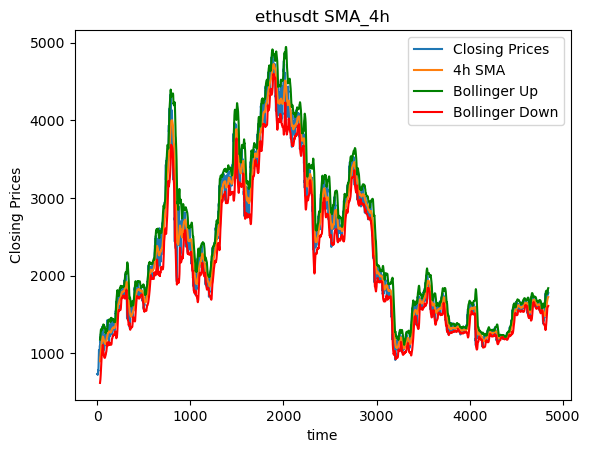

In [14]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()